In [41]:
# Load libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
# Load data and apply light cleaning for EDA

# Use a relative path to load the data
# ⚠️ This assumes the script is run from the root of the repo (where ML.py is located) on your local machine
# and that the CSV file is inside the 'raw_data/' folder.

file_path = os.path.join("..", "raw_data", "obesity_prediction.csv")

# Load the data
df = pd.read_csv(file_path)

# Check the first few rows
df.head()


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [36]:
# Categorical columns list
categorical_cols = [
    "Gender", "family_history", "FAVC", "CAEC", "SMOKE",
    "SCC", "CALC", "MTRANS", "Obesity"
]

# Encoded categorical columns list (ordinal variables encoded numerically)
encoded_categorical_cols = [
    "FCVC", "TUE", "FAF", "NCP", "CH2O"
]

# 1. Get the remaining columns (excluding categorical columns)
remaining_cols = [col for col in df.columns if (col not in categorical_cols and col not in encoded_categorical_cols)]

# 2. Check summary statistics for numerical columns
print("Summary statistics for numerical columns (excluding categorical):")
print(df[remaining_cols].describe())

# 3. Check unique values for categorical columns
for col in categorical_cols:
    print(f"Unique values in {col}:")
    print(df[col].value_counts())
    print("\n")

# 4. Check unique values for encoded categorical columns
for col in encoded_categorical_cols:
    print(f"Unique values in {col}:")
    print(df[col].value_counts())
    print("\n")

# 5. Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Summary statistics for numerical columns (excluding categorical):
               Age       Height       Weight
count  2111.000000  2111.000000  2111.000000
mean     24.312600     1.701677    86.586058
std       6.345968     0.093305    26.191172
min      14.000000     1.450000    39.000000
25%      19.947192     1.630000    65.473343
50%      22.777890     1.700499    83.000000
75%      26.000000     1.768464   107.430682
max      61.000000     1.980000   173.000000
Unique values in Gender:
Gender
Male      1068
Female    1043
Name: count, dtype: int64


Unique values in family_history:
family_history
yes    1726
no      385
Name: count, dtype: int64


Unique values in FAVC:
FAVC
yes    1866
no      245
Name: count, dtype: int64


Unique values in CAEC:
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64


Unique values in SMOKE:
SMOKE
no     2067
yes      44
Name: count, dtype: int64


Unique values in SCC:
SCC
no     2015
yes    

In [37]:

for col in encoded_categorical_cols:
    # Find rows where the value is not an integer (i.e., decimal values)
    is_decimal = df[col] != df[col].astype(int)  # This creates a boolean mask for decimal values
    
    # Count how many decimals exist per category in the column
    decimal_counts_per_category = df[is_decimal].groupby(col).size()
    
    print(f"Decimal values per category in {col}:")
    print(decimal_counts_per_category)
    print("\n")


Decimal values per category in FCVC:
FCVC
1.003566    1
1.005578    1
1.008760    1
1.031149    1
1.036159    1
           ..
2.996186    1
2.996717    1
2.997524    1
2.997951    1
2.998441    1
Length: 807, dtype: int64


Decimal values per category in TUE:
TUE
0.000073    1
0.000355    1
0.000436    1
0.001096    1
0.001330    1
           ..
1.978043    1
1.980875    1
1.983678    1
1.990617    1
1.992190    1
Length: 1126, dtype: int64


Decimal values per category in FAF:
FAF
0.000096    1
0.000272    1
0.000454    1
0.001015    1
0.001086    1
           ..
2.936551    1
2.939733    1
2.971832    1
2.998981    1
2.999918    1
Length: 1186, dtype: int64


Decimal values per category in NCP:
NCP
1.000283    1
1.000414    1
1.000610    1
1.001383    1
1.001542    1
           ..
3.995147    1
3.995957    1
3.998618    1
3.998766    1
3.999591    1
Length: 632, dtype: int64


Decimal values per category in CH2O:
CH2O
1.000463    1
1.000536    1
1.000544    1
1.000695    1
1.001307  

In [38]:
# Custom rounding for NCP to handle the special case where 2 is not valid
def custom_round_ncp(value):
    if value > 2:
        return 3
    else:
        return 1

# Round the decimal values to the nearest valid category for ordinal variables
df['FCVC'] = df['FCVC'].round().astype('category')
df['TUE'] = df['TUE'].round().astype('category')
df['FAF'] = df['FAF'].round().astype('category')

# Apply the custom rounding logic for NCP
df['NCP'] = df['NCP'].apply(custom_round_ncp).astype('category')

df['CH2O'] = df['CH2O'].round().astype('category')

# Re-encode the columns back to their respective categorical labels
fcvc_map = {1: 'Never', 2: 'Sometimes', 3: 'Always'}
tue_map = {0: '0-2 hours', 1: '3-5 hours', 2: 'More than 5 hours'}
faf_map = {0: 'I do not have', 1: '1 or 2 days', 2: '2 or 4 days', 3: '4 or 5 days'}
ncp_map = {1: 'Between 1 y 2', 3: 'Three', 4: 'More than three'}
ch2o_map = {1: 'Less than a liter', 2: 'Between 1 and 2 L', 3: 'More than 2 L'}

# Map the rounded values to the corresponding labels
df['FCVC'] = df['FCVC'].map(fcvc_map)
df['TUE'] = df['TUE'].map(tue_map)
df['FAF'] = df['FAF'].map(faf_map)
df['NCP'] = df['NCP'].map(ncp_map)
df['CH2O'] = df['CH2O'].map(ch2o_map)

# Check the updated DataFrame
print(df[['FCVC', 'TUE', 'FAF', 'NCP', 'CH2O']].head())


        FCVC        TUE            FAF            NCP               CH2O
0  Sometimes  3-5 hours  I do not have          Three  Between 1 and 2 L
1     Always  0-2 hours    4 or 5 days          Three      More than 2 L
2  Sometimes  3-5 hours    2 or 4 days          Three  Between 1 and 2 L
3     Always  0-2 hours    2 or 4 days          Three  Between 1 and 2 L
4  Sometimes  0-2 hours  I do not have  Between 1 y 2  Between 1 and 2 L


In [ ]:
print(df[['FCVC', 'TUE', 'FAF', 'NCP', 'CH2O']].isna().sum())

FCVC    0
TUE     0
FAF     0
NCP     0
CH2O    0
dtype: int64


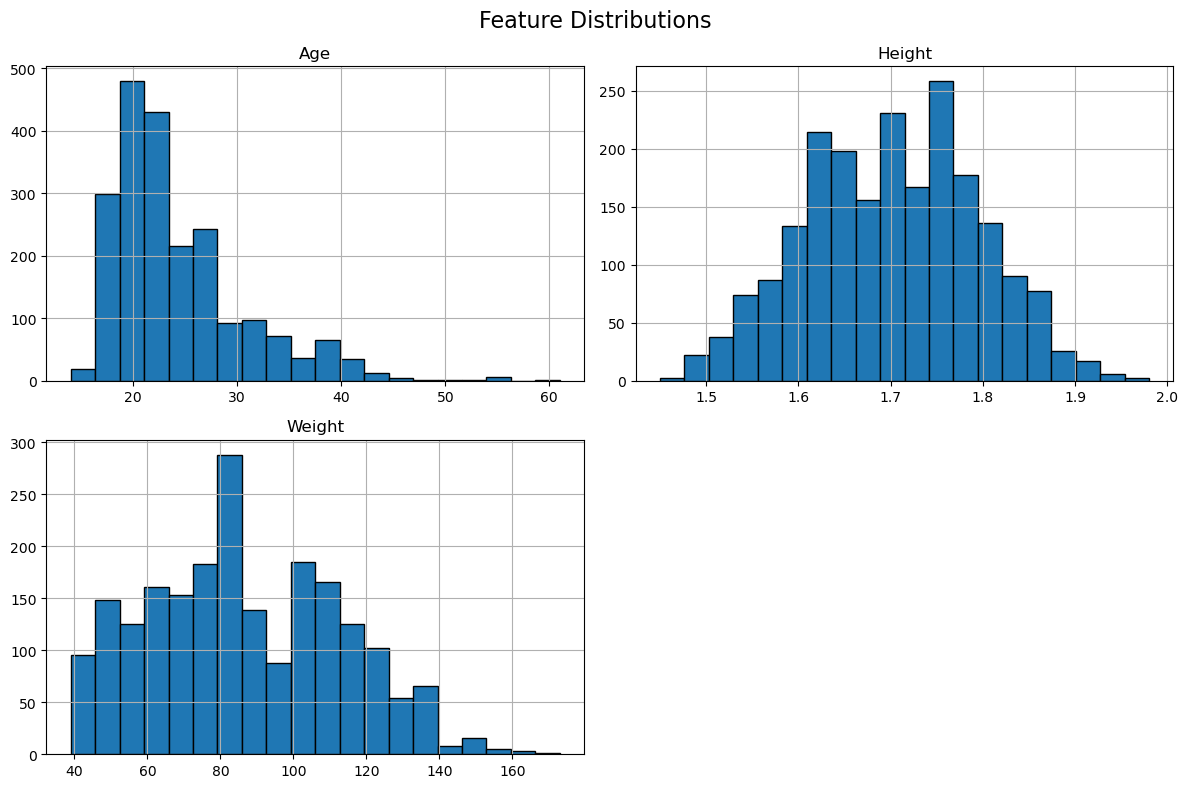

In [40]:
# Plot histograms for numerical features
df[remaining_cols].hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()


In [45]:
question_texts = {
    "Gender": "¿What is your gender?",
    "Age": "¿what is your age?",
    "Height": "¿what is your height?",
    "Weight": "¿what is your weight?",
    "family_history": "¿Has a family member suffered or suffers from overweight?",
    "FAVC": "¿Do you eat high caloric food frequently?",
    "FCVC": "¿Do you usually eat vegetables in your meals?",
    "NCP": "¿How many main meals do you have daily?",
    "CAEC": "¿Do you eat any food between meals?",
    "SMOKE": "¿Do you smoke?",
    "CH2O": "¿How much water do you drink daily?",
    "SCC": "¿Do you monitor the calories you eat daily?",
    "FAF": "¿How often do you have physical activity?",
    "TUE": "¿How much time do you use technological devices?",
    "CALC": "¿how often do you drink alcohol?",
    "MTRANS": "¿Which transportation do you usually use?"
}


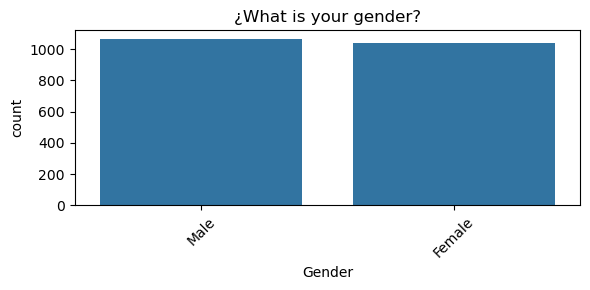

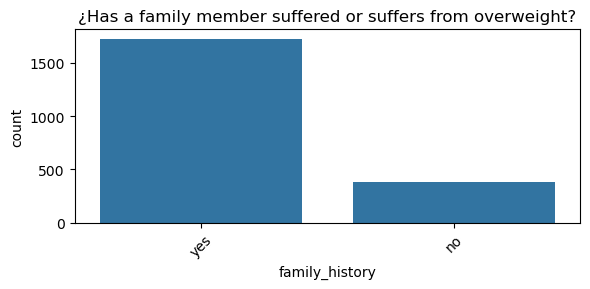

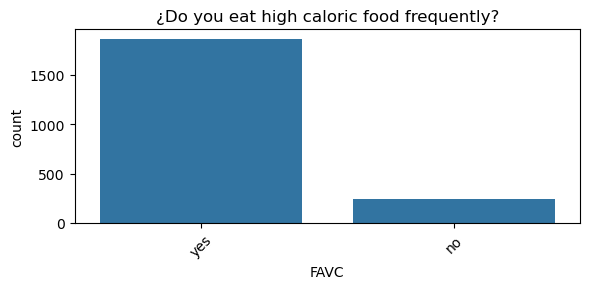

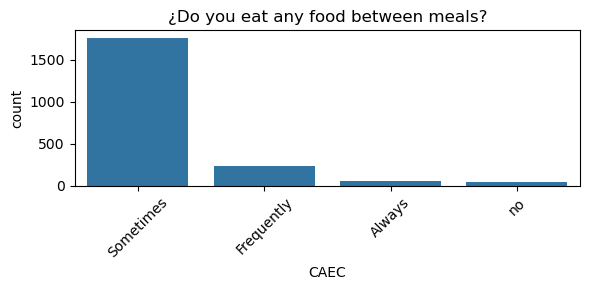

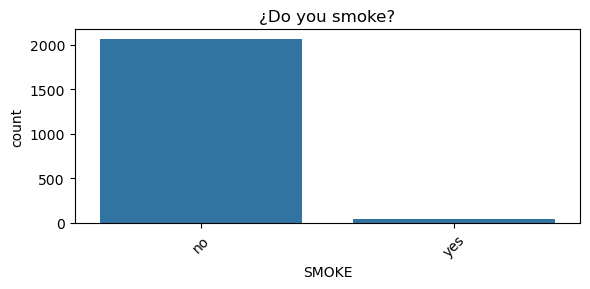

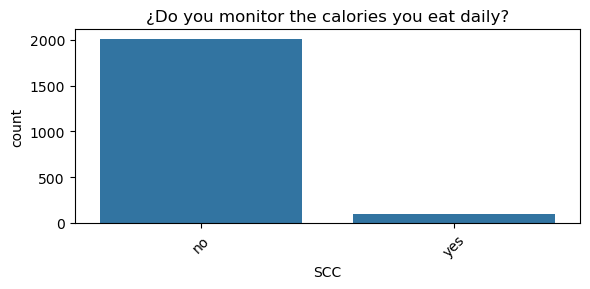

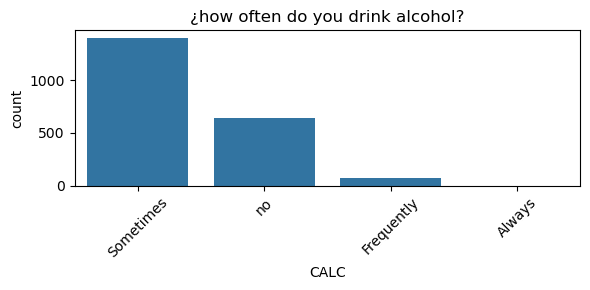

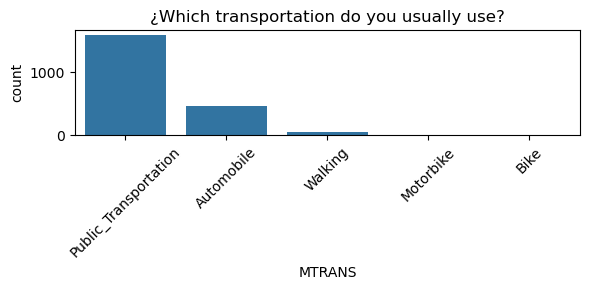

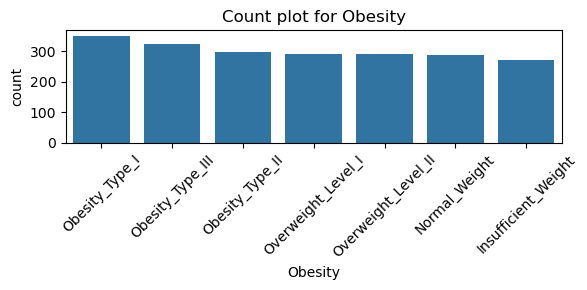

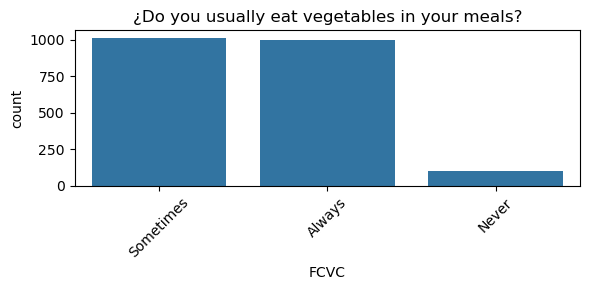

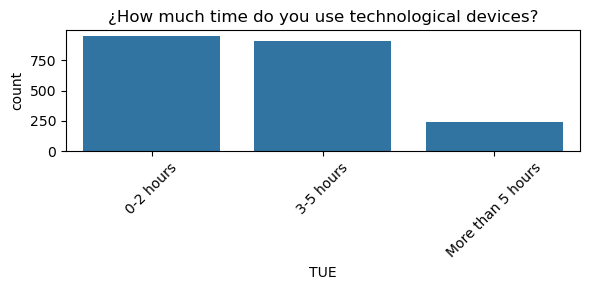

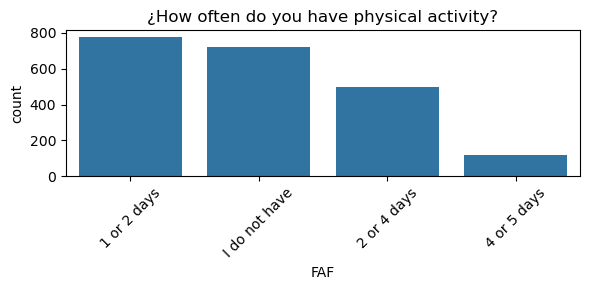

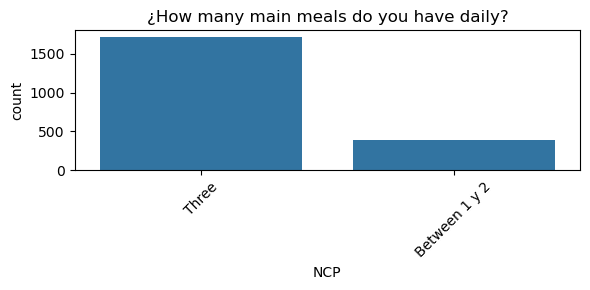

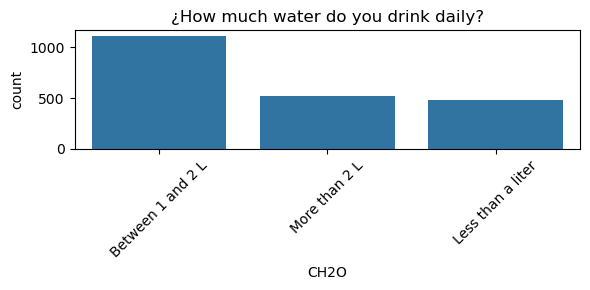

In [46]:
for col in categorical_cols + encoded_categorical_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(question_texts.get(col, f"Count plot for {col}"))  # Use question if available
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
